## **Libraries & Dependencies**

In [2]:
!pip install kagglehub

In [3]:
import kagglehub
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix

In [4]:
#Load dataset from kaggle-
path = kagglehub.dataset_download("grouplens/movielens-20m-dataset")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'movielens-20m-dataset' dataset.
Path to dataset files: /kaggle/input/movielens-20m-dataset


In [5]:
# Load ratings and movies
ratings = pd.read_csv(path + "/rating.csv")
movies = pd.read_csv(path + "/movie.csv")

print("Raw Ratings shape: (r,c)", ratings.shape)
print("Movies shape: (r,c)", movies.shape)

movies.head()


Raw Ratings shape: (r,c) (20000263, 4)
Movies shape: (r,c) (27278, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


## **Preprocessing**

In [7]:
# Check for NULLs
print("\nMissing values in ratings:\n", ratings.isnull().sum())
print("\nMissing values in movies:\n", movies.isnull().sum())


Missing values in ratings:
 userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in movies:
 movieId    0
title      0
genres     0
dtype: int64


In [8]:
# Count of each rating value
rating_counts = ratings['rating'].value_counts().sort_index()

print("Rating summary:\n")
for rating, count in rating_counts.items():
    print(f"Rating {rating}: {count} ratings")

# Check for any 0 or negative ratings
invalid_ratings = ratings[ratings['rating'] <= 0]
print(f"\nNumber of invalid ratings (0 or negative): {len(invalid_ratings)}")


Rating summary:

Rating 0.5: 239125 ratings
Rating 1.0: 680732 ratings
Rating 1.5: 279252 ratings
Rating 2.0: 1430997 ratings
Rating 2.5: 883398 ratings
Rating 3.0: 4291193 ratings
Rating 3.5: 2200156 ratings
Rating 4.0: 5561926 ratings
Rating 4.5: 1534824 ratings
Rating 5.0: 2898660 ratings

Number of invalid ratings (0 or negative): 0


In [9]:
duplicates = ratings.duplicated().sum()
print("\nDuplicate rating rows found:", duplicates)


Duplicate rating rows found: 0


## **✅Interaction Matrix**

In [10]:
# Drop unnecessary columns

ratings.columns = ratings.columns.str.strip() # Strip any leading/trailing spaces from column names

#drop timestamp
ratings = ratings.drop(columns=['timestamp'])


# Encode userId and movieId into continuous indices
ratings['userId'] = ratings['userId'].astype('category')
ratings['movieId'] = ratings['movieId'].astype('category')

user_map = dict(enumerate(ratings['userId'].cat.categories))
movie_map = dict(enumerate(ratings['movieId'].cat.categories))

user_codes = ratings['userId'].cat.codes
movie_codes = ratings['movieId'].cat.codes

In [11]:
# Build sparse user-item interaction matrix
interaction_matrix = coo_matrix(
    (ratings['rating'].astype(float), (user_codes, movie_codes))
)

print("\nInteraction matrix shape:", interaction_matrix.shape)#prints- (r,c) of (users,movies)


Interaction matrix shape: (138493, 26744)


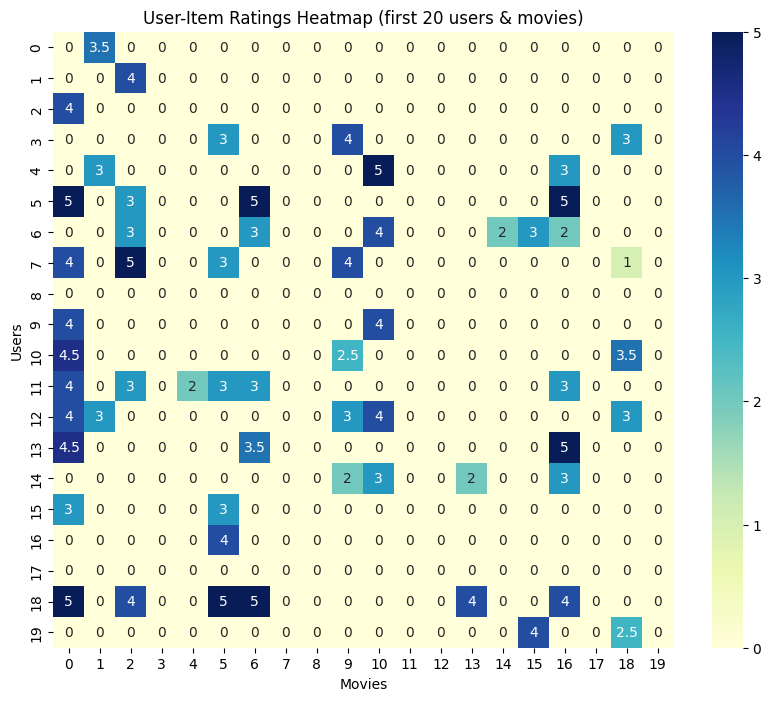

In [12]:
#Heatmap for visualizing(shows: 0 if not rated, shows actual rating if Rated)
from scipy.sparse import coo_matrix

import seaborn as sns
import matplotlib.pyplot as plt


interaction_csr = interaction_matrix.tocsr()

# Take a small slice and convert to dense array
small_matrix = interaction_csr[:20, :20].toarray()

plt.figure(figsize=(10,8))
sns.heatmap(small_matrix, annot=True, cmap='YlGnBu', cbar=True)
plt.xlabel('Movies')
plt.ylabel('Users')
plt.title('User-Item Ratings Heatmap (first 20 users & movies)')
plt.show()



## **Implement Collaborative Filtering**

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import coo_matrix

# Filter to smaller subset
filtered_users = ratings['userId'].cat.codes < 20000   # first 20k users
filtered_movies = ratings['movieId'].cat.codes < 2000  # first 2k movies

subset = ratings[filtered_users & filtered_movies]

# Re-encode IDs for the subset
subset['userId'] = subset['userId'].astype('category')
subset['movieId'] = subset['movieId'].astype('category')

user_codes = subset['userId'].cat.codes
movie_codes = subset['movieId'].cat.codes

/tmp/ipython-input-1621226095.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['userId'] = subset['userId'].astype('category')
/tmp/ipython-input-1621226095.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['movieId'] = subset['movieId'].astype('category')


In [14]:
# ---- Step 2: Build user-item interaction matrix ----
interaction_matrix = coo_matrix(
    (subset['rating'].astype(float), (user_codes, movie_codes))
)
print("Subset interaction matrix shape (users x movies):", interaction_matrix.shape)

Subset interaction matrix shape (users x movies): (20000, 2000)


In [15]:
#Convert to CSR format
interaction_csr = interaction_matrix.tocsr()

# Compute Similarities-

item_similarity = cosine_similarity(interaction_csr.T) # Item-Item Collaborative Filtering
print("Item-item similarity matrix shape:", item_similarity.shape)

user_similarity = cosine_similarity(interaction_csr) # User-User Collaborative Filtering
print("User-user similarity matrix shape:", user_similarity.shape)

Item-item similarity matrix shape: (2000, 2000)
User-user similarity matrix shape: (20000, 20000)


## **Explore Matrix Factorization:**

In [16]:
#Singular Value Decomposition (SVD)
from numpy.linalg import svd

# Convert subset user-item matrix to dense array
user_item_matrix = subset.pivot(index='userId', columns='movieId', values='rating').fillna(0)
print("User-item matrix shape:", user_item_matrix.shape)

User-item matrix shape: (19972, 1993)


In [17]:
# Convert to numpy
R = user_item_matrix.values

# Perform SVD
U, sigma, Vt = svd(R, full_matrices=False)

# Keep top-k latent features
k = 50  # you can adjust (trade-off between speed and accuracy)
sigma_k = np.diag(sigma[:k])
U_k = U[:, :k]
Vt_k = Vt[:k, :]

# Predicted ratings
R_pred = np.dot(np.dot(U_k, sigma_k), Vt_k)
R_pred_df = pd.DataFrame(R_pred, index=user_item_matrix.index, columns=user_item_matrix.columns)

print("Predicted rating matrix shape:", R_pred_df.shape)

Predicted rating matrix shape: (19972, 1993)


In [18]:
#Recommendation Function using SVD
def recommend_movies_svd(user_id, N=5):
    """
    Recommend Top-N movies for a given user using SVD predictions.
    """
    # Get predicted ratings for this user
    user_ratings = R_pred_df.loc[user_id]

    # Remove already rated movies
    already_rated = user_item_matrix.loc[user_id][user_item_matrix.loc[user_id] > 0].index
    recommendations = user_ratings.drop(already_rated)

    # Get Top-N recommendations
    top_movies = recommendations.sort_values(ascending=False).head(N).index
    recommended_titles = movies[movies['movieId'].isin(top_movies)]['title'].tolist()

    return recommended_titles

In [19]:
print("Example user IDs in user_item_matrix:")
print(user_item_matrix.index[:10])  # show first 10 IDs


Example user IDs in user_item_matrix:
CategoricalIndex([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], categories=[1, 2, 3, 4, ..., 138490, 138491, 138492, 138493], ordered=False, dtype='category', name='userId')


In [20]:
print("Top 5 recommendations for an user using SVD:")
print(recommend_movies_svd(user_id=10, N=5))


print("Top 5 recommendations for another user using SVD:")
print(recommend_movies_svd(user_id=2, N=5))

Top 5 recommendations for an user using SVD:
["One Flew Over the Cuckoo's Nest (1975)", 'Alien (1979)', 'Boot, Das (Boat, The) (1981)', 'Patton (1970)', 'Indiana Jones and the Last Crusade (1989)']
Top 5 recommendations for another user using SVD:
['Independence Day (a.k.a. ID4) (1996)', 'E.T. the Extra-Terrestrial (1982)', 'Aliens (1986)', 'Terminator, The (1984)', 'Fifth Element, The (1997)']


In [52]:
import pickle

# Shrink to 2000 users × 1000 movies
small_R = R_pred_df.iloc[:2000, :1000]
small_UI = user_item_matrix.iloc[:2000, :1000]

pickle.dump(small_R, open("R_pred_df.pkl", "wb"))
pickle.dump(small_UI, open("user_item_matrix.pkl", "wb"))

# Also shrink movie metadata
small_movies = movies[movies['movieId'].isin(small_R.columns)]
small_movies.to_csv("movie.csv", index=False)


### **Visualize Singular Values**
***The scree plot of singular values shows that the first few latent factors capture most of the variance in the data, with values decreasing sharply before flattening out. This means that user–movie interactions can be represented efficiently using a small set of hidden features, such as genre preferences or movie popularity trends. Based on this observation, we retained the top 50 features (k=50) for matrix factorization, balancing accuracy and computational cost.***

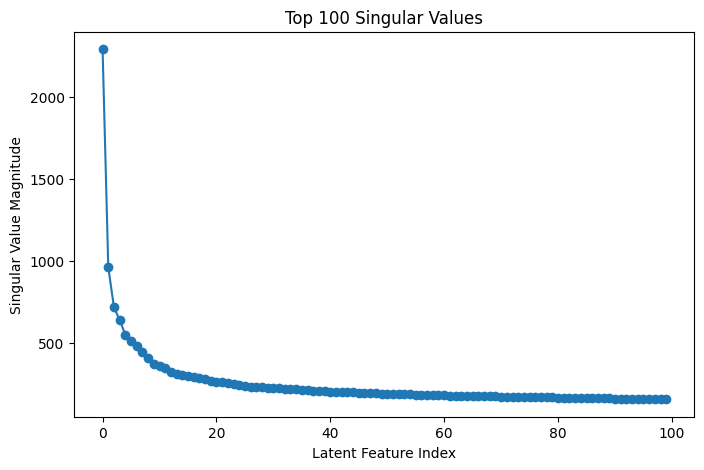

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(sigma[:100], marker='o')
plt.title("Top 100 Singular Values")
plt.xlabel("Latent Feature Index")
plt.ylabel("Singular Value Magnitude")
plt.show()


### **Compare Original vs. Predicted**


 If predictions align with actuals, points lie closer to diagonal.




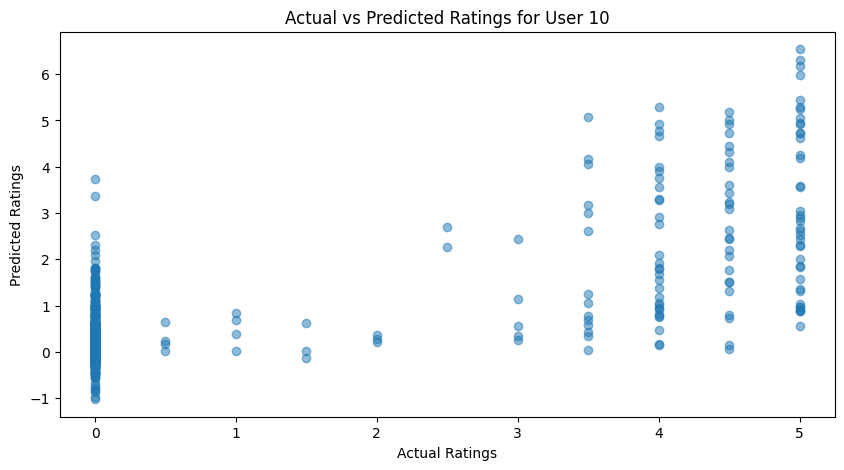

In [22]:
user_idx = 10  # picked id = 10 user
actual_ratings = user_item_matrix.iloc[user_idx]
predicted_ratings = R_pred_df.iloc[user_idx]

plt.figure(figsize=(10,5))
plt.scatter(actual_ratings, predicted_ratings, alpha=0.5)
plt.xlabel("Actual Ratings")
plt.ylabel("Predicted Ratings")
plt.title(f"Actual vs Predicted Ratings for User {user_idx}")
plt.show()


## **Optional Enhancement:**
Experiment with neural embeddings or deep learning-based approaches to
improve recommendation quality.

In [23]:
#Neural Collaborative Filtering (NCF)
!pip install torch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#Prepare data

class RatingDataset(Dataset):
    def __init__(self, ratings):
        self.user_ids = torch.tensor(ratings['userId'].cat.codes.values, dtype=torch.long)
        self.movie_ids = torch.tensor(ratings['movieId'].cat.codes.values, dtype=torch.long)
        self.ratings = torch.tensor(ratings['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.user_ids[idx], self.movie_ids[idx], self.ratings[idx]


In [24]:
# Small subset for demo
sample_ratings = ratings.sample(50000, random_state=42)  # 50k ratings

dataset = RatingDataset(sample_ratings)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

n_users = sample_ratings['userId'].cat.categories.size
n_movies = sample_ratings['movieId'].cat.categories.size

In [25]:
# Step 2: Define Neural Model
class NeuralCF(nn.Module):
    def __init__(self, n_users, n_movies, embedding_dim=32):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.movie_embedding = nn.Embedding(n_movies, embedding_dim)

        # Feedforward layers
        self.fc1 = nn.Linear(embedding_dim*2, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, user, movie):
        u = self.user_embedding(user)
        m = self.movie_embedding(movie)
        x = torch.cat([u, m], dim=1)  # combine user and movie embeddings
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x.squeeze()

model = NeuralCF(n_users, n_movies)

In [26]:
#Train Model with Early Stopping

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 100            # maximum epochs
patience = 3           # stop if no improvement for 3 epochs
min_delta = 0.0001     # minimum change in loss to count as improvement

best_loss = float("inf")
patience_counter = 0

for epoch in range(epochs):
    total_loss = 0
    for user, movie, rating in dataloader:
        optimizer.zero_grad()
        predictions = model(user, movie)
        loss = criterion(predictions, rating)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    # Check for improvement
    if best_loss - avg_loss > min_delta:
        best_loss = avg_loss
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping condition
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}, loss has stabilized.")
        break


Epoch 1/100, Loss: 4.7275
Epoch 2/100, Loss: 1.1954
Epoch 3/100, Loss: 1.1122
Epoch 4/100, Loss: 1.0488
Epoch 5/100, Loss: 0.9979
Epoch 6/100, Loss: 0.9508
Epoch 7/100, Loss: 0.9115
Epoch 8/100, Loss: 0.8729
Epoch 9/100, Loss: 0.8372
Epoch 10/100, Loss: 0.8017
Epoch 11/100, Loss: 0.7683
Epoch 12/100, Loss: 0.7339
Epoch 13/100, Loss: 0.6987
Epoch 14/100, Loss: 0.6628
Epoch 15/100, Loss: 0.6251
Epoch 16/100, Loss: 0.5850
Epoch 17/100, Loss: 0.5423
Epoch 18/100, Loss: 0.4986
Epoch 19/100, Loss: 0.4532
Epoch 20/100, Loss: 0.4098
Epoch 21/100, Loss: 0.3662
Epoch 22/100, Loss: 0.3242
Epoch 23/100, Loss: 0.2866
Epoch 24/100, Loss: 0.2526
Epoch 25/100, Loss: 0.2203
Epoch 26/100, Loss: 0.1929
Epoch 27/100, Loss: 0.1686
Epoch 28/100, Loss: 0.1464
Epoch 29/100, Loss: 0.1274
Epoch 30/100, Loss: 0.1103
Epoch 31/100, Loss: 0.0956
Epoch 32/100, Loss: 0.0827
Epoch 33/100, Loss: 0.0716
Epoch 34/100, Loss: 0.0618
Epoch 35/100, Loss: 0.0533
Epoch 36/100, Loss: 0.0460
Epoch 37/100, Loss: 0.0396
Epoch 38/1

In [28]:
def recommend_movies_nn(user_id, N=5):
    # user_id must be original MovieLens ID
    try:
        user_code = sample_ratings['userId'].cat.categories.get_loc(user_id)
    except KeyError:
        return [f"User {user_id} not found in this subset"]

    all_movie_codes = torch.arange(n_movies)
    user_tensor = torch.tensor([user_code]*n_movies)

    with torch.no_grad():
        scores = model(user_tensor, all_movie_codes).numpy()

    top_indices = scores.argsort()[-N:][::-1]
    recommended_movie_ids = sample_ratings['movieId'].cat.categories[top_indices]
    recommended_titles = movies[movies['movieId'].isin(recommended_movie_ids)]['title'].tolist()

    return recommended_titles

print("Top 5 Recommended movie for this user are:",recommend_movies_nn(user_id=1, N=5))


Top 5 Recommended movie for this user are: ['Me Too (Yo, también) (2009)', 'The Great Northfield Minnesota Raid (1972)', 'Big Bad Wolves (2013)', 'Reckoning, The (2014)', '1001 Nights (1990)']


## **Evaluation Metrics:**
Evaluate model performance using metrics like:

---

○ Precision@K
○ Recall@K
○ NDCG (Normalized Discounted Cumulative Gain)

In [32]:
# Evaluate Across Multiple Users
def evaluate_model(R_pred_df, user_item_matrix, k=10, n_users_eval=100):
    precision_list, recall_list, ndcg_list = [], [], []

    # Pick a sample of users (to save time)
    users_to_eval = user_item_matrix.index[:n_users_eval]

    for user in users_to_eval:
        actual_movies = list(user_item_matrix.loc[user][user_item_matrix.loc[user] > 0].index)

        # Skip if no ratings
        if len(actual_movies) == 0:
            continue

        predicted_movies = R_pred_df.loc[user].sort_values(ascending=False).index.tolist()

        precision_list.append(precision_at_k(predicted_movies, actual_movies, k))
        recall_list.append(recall_at_k(predicted_movies, actual_movies, k))
        ndcg_list.append(ndcg_at_k(predicted_movies, actual_movies, k))

    return {
        "Precision@K": np.mean(precision_list),
        "Recall@K": np.mean(recall_list),
        "NDCG@K": np.mean(ndcg_list)
    }

# Example: Evaluate SVD predictions on 100 users
results = evaluate_model(R_pred_df, user_item_matrix, k=10, n_users_eval=100)
print("Average results on 100 users:")
print(results)


Average results on 100 users:
{'Precision@K': np.float64(0.8690000000000001), 'Recall@K': np.float64(0.2577302415758474), 'NDCG@K': np.float64(0.906148458310617)}


In [38]:
 #Collaborative Filtering Evaluation
sample_user = user_item_matrix.index[3]
print("Evaluating for user:", sample_user)

# Get user's ratings
user_idx = list(user_item_matrix.index).index(sample_user)
user_ratings = interaction_csr[user_idx].toarray().flatten()

# Predict with item-based CF
cf_scores = item_similarity.dot(user_ratings)
cf_scores[user_ratings > 0] = -1  # remove already rated movies

# Ranking from CF
predicted_cf = np.argsort(cf_scores)[::-1]
actual_cf = list(user_item_matrix.loc[sample_user][user_item_matrix.loc[sample_user] > 0].index)

# Metrics
print("\nCF Metrics:")
print("Precision@10:", precision_at_k(predicted_cf, actual_cf, k=10))
print("Recall@10:", recall_at_k(predicted_cf, actual_cf, k=10))
print("NDCG@10:", ndcg_at_k(predicted_cf, actual_cf, k=10))



Evaluating for user: 4

CF Metrics:
Precision@10: 0.1
Recall@10: 0.03571428571428571
NDCG@10: 0.13886244387355454


In [37]:
#Collaborative Filtering Evaluation
sample_user = user_item_matrix.index[3]
print("Evaluating for user:", sample_user)
# Predicted ranking from SVD
predicted_svd = R_pred_df.loc[sample_user].sort_values(ascending=False).index.tolist()
actual_svd = list(user_item_matrix.loc[sample_user][user_item_matrix.loc[sample_user] > 0].index)

# Metrics
print("\nSVD Metrics:")
print("Precision@10:", precision_at_k(predicted_svd, actual_svd, k=10))
print("Recall@10:", recall_at_k(predicted_svd, actual_svd, k=10))
print("NDCG@10:", ndcg_at_k(predicted_svd, actual_svd, k=10))



Evaluating for user: 4

SVD Metrics:
Precision@10: 0.7
Recall@10: 0.25
NDCG@10: 0.7534494445524138


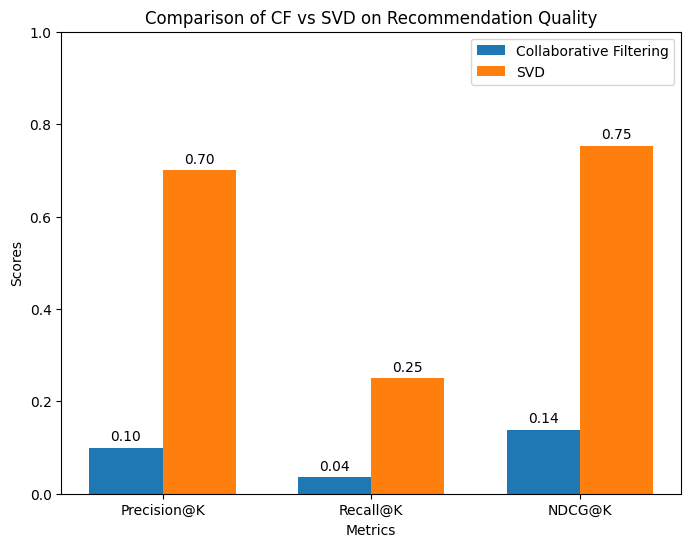

In [46]:
import matplotlib.pyplot as plt
import numpy as np

# Results you got (for user 4 as example)
cf_results = {"Precision@K": 0.10, "Recall@K": 0.0357, "NDCG@K": 0.139}
svd_results = {"Precision@K": 0.70, "Recall@K": 0.25, "NDCG@K": 0.753}

# Organize results
models = ["Collaborative Filtering", "SVD"]
metrics = list(cf_results.keys())

results = [
    [cf_results[m] for m in metrics],
    [svd_results[m] for m in metrics]
]

# Convert to numpy for plotting
results = np.array(results)

# Plot
x = np.arange(len(metrics))  # metric positions
width = 0.35

fig, ax = plt.subplots(figsize=(8,6))

# Bars for CF and SVD
rects1 = ax.bar(x - width/2, results[0], width, label="Collaborative Filtering")
rects2 = ax.bar(x + width/2, results[1], width, label="SVD")

# Formatting
ax.set_ylabel("Scores")
ax.set_xlabel("Metrics")
ax.set_title("Comparison of CF vs SVD on Recommendation Quality")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0,1.0)
ax.legend()

# Add bar labels
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # offset
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.show()
